#### Predict which Tweets are about real disasters and which ones are not

the purpose of this notebook is to analyze and explore the given dataset ' df_train ' and create a machine learning model to be able to classify test tweets data into announcing disaster or not.

The general approach to preprocessing text data with NLTK
The following diagram shows the general idea of the preprocessing pipeline from text (e.g., books, articles, news) to a list of words:

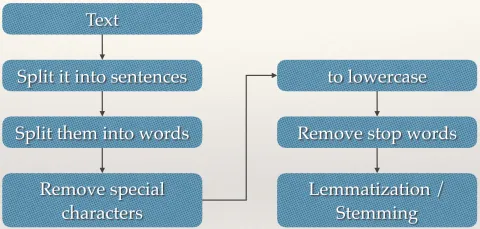

This pipeline can be more generalized to: Text -> Tokenization -> Normalization -> A list of words. Let’s look at details step by step.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #numerical math extension of numpy ,the plots
import seaborn as sns#statistical graphs
import plotly.offline as py #online graphing and analysing
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import nltk # for nlp
from string import punctuation
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
  
wn = WordNetLemmatizer()
from nltk.tokenize import word_tokenize

ps = PorterStemmer()
import string

In [2]:
df_train = pd.read_csv('nlptrain.csv')
df_test = pd.read_csv('nlptest.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


##### exploring the data

In [6]:
df_train.shape

(7613, 5)

In [7]:
df_train.shape[0] # number of records

7613

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 208.2+ KB


In [9]:
# similarly check with the test data
df_test.shape

(3263, 4)

In [10]:
df_test.shape[0]

3263

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 63.8+ KB


###### checking the missing values

In [13]:
df_train.keyword.isnull().sum()

61

In [24]:
#inorder to check the percentage of records missing
print('{}% of location values are missing from Total Number of Records.'.format(round((df_train.location.isnull().sum())/(df_train.shape[0])*100),2))
print('{}% of keywords values are missing from Total Number of Records.'.format(round((df_train.keyword.isnull().sum())/(df_train.shape[0])*100),2))

33.0% of location values are missing from Total Number of Records.
1.0% of keywords values are missing from Total Number of Records.


In [26]:
df_test.keyword.isnull().sum()

26

In [27]:
#inorder to check the percentage of records missing
print('{}% of location values are missing from Total Number of Records.'.format(round((df_test.location.isnull().sum())/(df_test.shape[0])*100),2))
print('{}% of keywords values are missing from Total Number of Records.'.format(round((df_test.keyword.isnull().sum())/(df_test.shape[0])*100),2))

34.0% of location values are missing from Total Number of Records.
1.0% of keywords values are missing from Total Number of Records.


In [29]:
df_train.text.isnull().sum()

0

In [30]:
df_test.text.isnull().sum()

0

from the above we can conclude that location column has lots of missing values than others and comparitively it doesnt have much to do with the prediction ,hence we can drop it. 

In [37]:
df_train["location"].nunique()


3341

In [38]:
df_test["location"].nunique()

1602

In [39]:
df_train["keyword"].nunique()

221

In [40]:
df_test["keyword"].nunique()

221

in the target 0 represents not a disaster and 1 represents the disaster,
now lets visualize the relation between the keywords and target

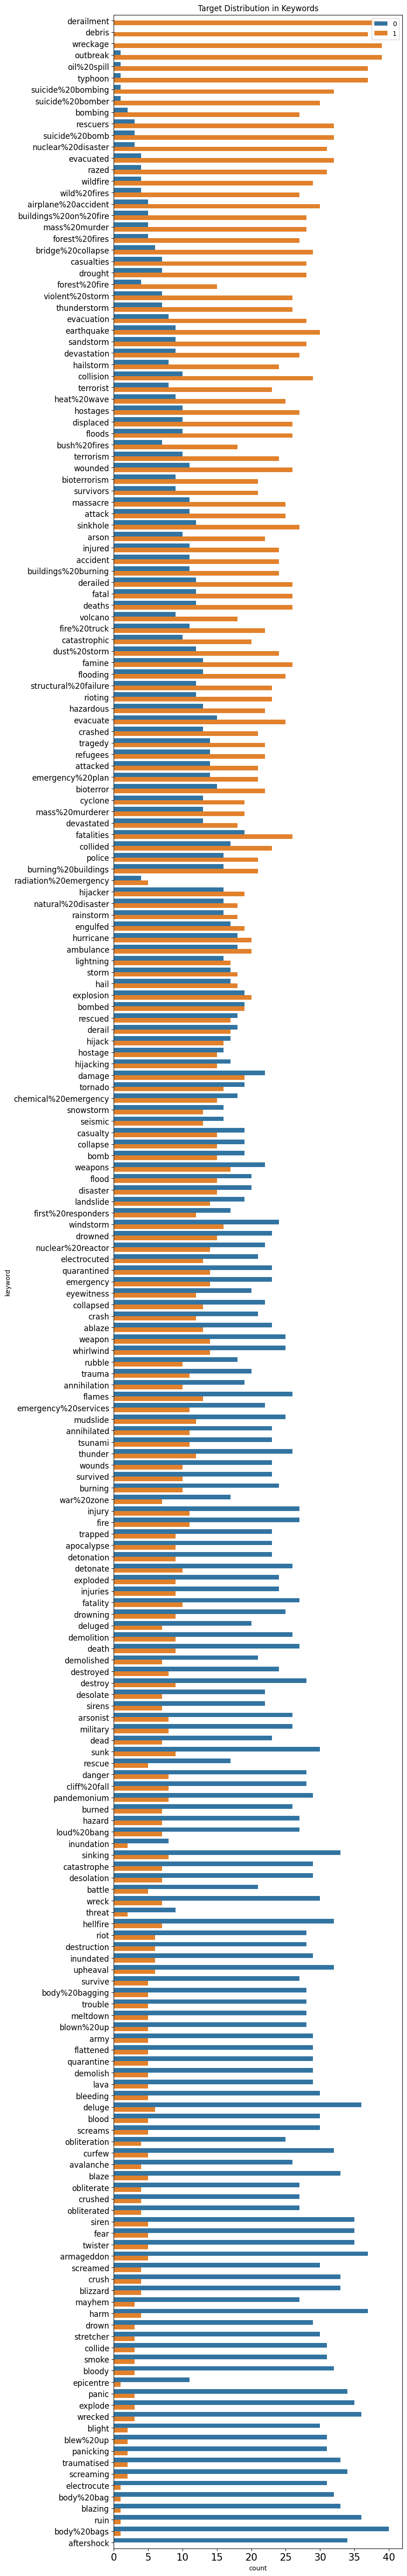

In [41]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()


In [42]:
df_train.drop(columns=['target_mean'], inplace=True)

When inplace = True , the data is modified in place, which means it will return nothing and the dataframe is now updated. When inplace = False , which is the default, then the operation is performed and it returns a copy of the object. You then need to save it to something.


Target of 0 is 57.0 % of total
Target of 1 is 43.0 % of total


c:\users\anush\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'samples')

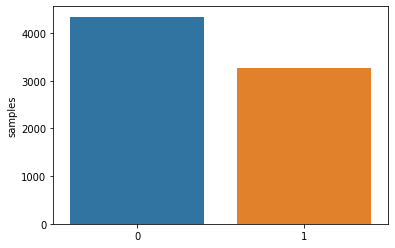

In [43]:
print('Target of 0 is {} % of total'.format(round(df_train['target'].value_counts()[0]/len(df_train['target'])*100)))
print('Target of 1 is {} % of total'.format(round(df_train['target'].value_counts()[1]/len(df_train['target'])*100)))
x=df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

we can clearly see there more tweets with class 0 than 1

lets check with the  top 10 locations

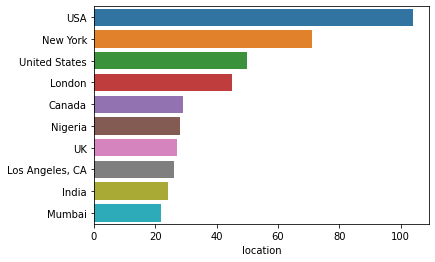

In [44]:
sns.barplot(y=df_train['location'].value_counts()[:10].index,x=df_train['location'].value_counts()[:10],orient='h');

Since it doesn't seem that location feature has any value or correlation to our problem to be solved, it could be dropped from the data frame.

In [45]:
# Drop the column 'location' from the training dataset
df_train=df_train.drop(['location'],axis=1)

Let’s look at what the disaster and the non disaster tweets look like.

In [46]:
# A disaster tweet exmaple
df_train[df_train['target']==1]['text'][10:20]

10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
37    INEC Office in Abia Set Ablaze - http://t.co/3...
38    Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
46    How the West was burned: Thousands of wildfire...
Name: text, dtype: object

In [47]:
#A non-disaster tweet example
df_train[df_train['target']==0]['text'][10:20]

25                       No way...I can't eat that shit
26                                Was in NYC last week!
27                                   Love my girlfriend
28                                            Cooool :)
29                                   Do you like pasta?
30                                             The end!
32    We always try to bring the heavy. #metal #RT h...
34                   Crying out for more! Set me ablaze
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36    @PhDSquares #mufc they've built so much hype a...
Name: text, dtype: object

We can see clearly that disaster tweets are written in a more formal way with longer words compared to non-disaster tweets

In [48]:
df_train['words_count'] = df_train['text'].str.split().map(lambda x: len(x))
df_train.head()

,id,keyword,text,target,words_count
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


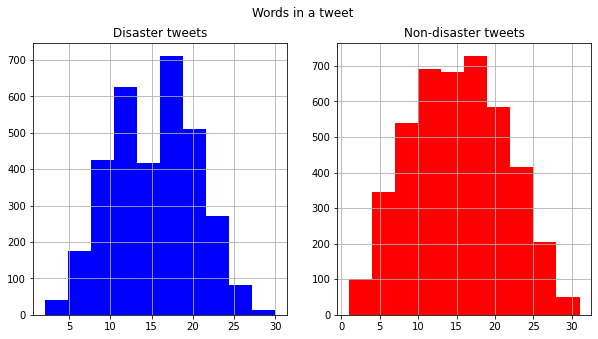

In [49]:
#Create visualization of the distribution of the word counts in comparision to target feature
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
dis_tweet=df_train[df_train['target']==1]['words_count']
ax1.hist(dis_tweet,color='blue')
ax1.set_title('Disaster tweets')
ax1.grid()
nondis_tweet=df_train[df_train['target']==0]['words_count']
ax2.hist(nondis_tweet,color='red')
ax2.set_title('Non-disaster tweets')
ax2.grid()
fig.suptitle('Words in a tweet')
plt.show()

Lets further analyze the text feature and if there is any correlation between text content and length of the tweets itself.

Adding a new column text_length to train dataset

In [50]:
df_train['text_length'] = df_train['text'].apply(lambda x : len(x))
df_train.head()

,id,keyword,text,target,words_count,text_length
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88


c:\users\anush\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



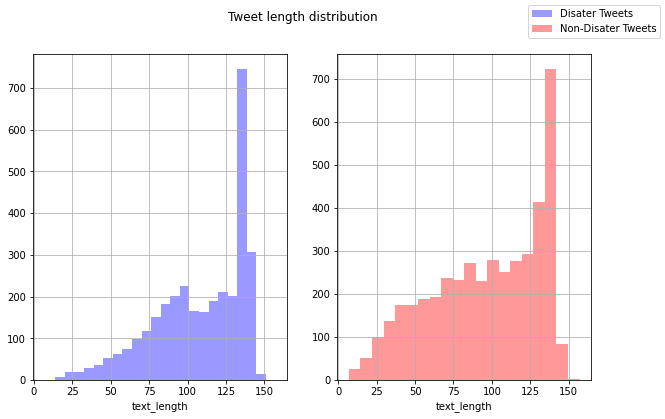

In [51]:
#Create visualization of the distribution of text length in comparision to target feature
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(df_train[(df_train['target'] == 1)]['text_length'], ax=ax1, kde=False, color='blue',label='Disater Tweets')
sns.distplot(df_train[(df_train['target'] == 0)]['text_length'],ax=ax2, kde=False, color='red',label='Non-Disater Tweets');
f.suptitle('Tweet length distribution')
f.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()

##### data preprocessing 


###### cleaning up and structuring

Before starting any NLP project, text data needs to be pre-processed to convert it into in a consistent format.Text will be cleaned, tokneized and converted into a matrix.

##### 1.remove punctuations

Punctuation can provide grammatical context to a sentence which supports our understanding.
Classic chinese doesn't have punctuations. It indicates that they are helpful but not absolutely necessary.
But for our vectorizer which counts the number of words and not the context, it does not add value.
So we remove all special characters.

In [52]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation ]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Remove punctuation from both train and test dataset
df_train['text_wo_punct']=df_train['text'].apply(lambda x: remove_punctuation(x))
df_test['text_wo_punct']=df_test['text'].apply(lambda x: remove_punctuation(x))

df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...


#### 2.tokenization

Tokenizing separates text into units such as sentences or words.

It generates a list structure of unstructured text

It is also referred to as text segmentation or lexical analysis.

The general approach works well for any language that uses space as delimiter.

For those languages that don't use space delimiter, the options can be

greedy algorithm: It always looks for the longest word in the dictionary that matches the input, one at a time
Tokenizing ancient language poem will be challenging.
Won't work well on new words.
Build ML algorithms to tokenize.
and many other algorithms based on stats and deep learning

In [55]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
df_train['text_wo_punct_split']=df_train['text_wo_punct'].apply(lambda x: tokenize(x.lower())) # we convert to lower as python is case sensitive
df_test['text_wo_punct_split']=df_test['text_wo_punct'].apply(lambda x: tokenize(x.lower()))

df_train.head()
#Here, “\W+” splits on one or more non-word character

,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


#### 3. stop words

Stopwords are common words that will likely appear in any text.

They usually don't have much useful information of our data so we remove them

In [57]:
stopword = nltk.corpus.stopwords.words('english')
print(stopword[:11]) # there are 179 stopwords in the library

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


In [58]:
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

df_train['text_wo_punct_split_wo_stopwords']=df_train['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
df_test['text_wo_punct_split_wo_stopwords']=df_test['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


#### 4.lemmatize/stem
Stemming and Lemmatizing is the process of reducing a word to its root form. The main purpose is to reduce variations of the same word, thereby reducing the corpus of words we include in the model. The difference between stemming and lemmatizing is that, stemming chops off the end of the word without taking into consideration the context of the word. Whereas, Lemmatizing considers the context of the word and shortens the word into its root form based on the dictionary definition. Stemming is a faster process compared to Lemmantizing. Hence, it a trade-off between speed and accuracy.

Let’s consider the word “belief” for example. The different variations of believe can be believing, believed, believes, and believe .

In [59]:
print(ps.stem('believe'))
print(ps.stem('believing'))
print(ps.stem('believed'))
print(ps.stem('believes'))

believ
believ
believ
believ


In [60]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer=nltk.stem.WordNetLemmatizer()

print(lemmatizer.lemmatize('believe'))
print(lemmatizer.lemmatize('believing'))
print(lemmatizer.lemmatize('believed'))
print(lemmatizer.lemmatize('believes'))

believe
believing
believed
belief


The lemmatize results in the order of print statements are — believe, believing, believed, and belief. Lemmatize produces the same result if the word is not in the corpus. Believe is lemmatized to belief (the root word)

We are going lemmatize our text

In [61]:
def lemmatize_text(word_list):
    
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output


df_train['text_wo_punct_split_wo_stopwords_lim']=df_train['text_wo_punct_split_wo_stopwords'].apply(lambda x: lemmatize_text(x))
df_test['text_wo_punct_split_wo_stopwords_lim']=df_test['text_wo_punct_split_wo_stopwords'].apply(lambda x: lemmatize_text(x))
df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords,text_wo_punct_split_wo_stopwords_lim
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive u
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",resident asked shelter place notified officer ...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...",13000 people receive wildfire evacuation order...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


##### 5.other cleaning steps

1.Remove URLs
2.Remove HTML tags
3.Remove emoji
4.Remove numbers 



In [62]:
def text_clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('<.*?>+', '', text)
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [63]:
df_train['clean_text']=df_train['text_wo_punct_split_wo_stopwords_lim'].apply(lambda x: text_clean(x))
df_test['clean_text']=df_test['text_wo_punct_split_wo_stopwords_lim'].apply(lambda x: text_clean(x))
df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords,text_wo_punct_split_wo_stopwords_lim,clean_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive u,deed reason earthquake may allah forgive u
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",resident asked shelter place notified officer ...,resident asked shelter place notified officer ...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...",13000 people receive wildfire evacuation order...,people receive wildfire evacuation order cali...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...,got sent photo ruby alaska smoke wildfire pour...


### Text Vectorization

Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics.

To convert string data into numerical data one can use following methods

· Bag of words
· TFIDF
· Word2Vec
Google Word2Vec
It is deep learning technique with two-layer neural network.Google Word2vec take input from large data and convert into vector space. Google word2vec is basically pretrained on google dataset.

Word2vec basically place the word in the feature space is such a way that their location is determined by their meaning i.e. words having similar meaning are clustered together and the distance between two words also have same meaning. Consider an example given below:

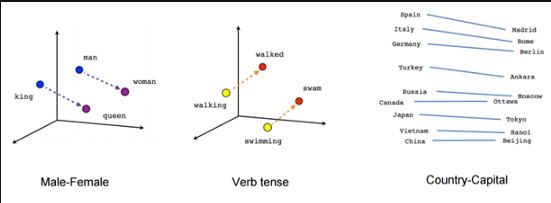

Bag of Words The bag of words is a representation of text that describes the occurrence of words within a document. It involves two things:
A vocabulary of known words.
A measure of the presence of known words.
Why is it is called a “bag” of words?

Its called bag of words because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

Bag of Words - Countvectorizer Features Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal. However, all the pre-processing of the text has already been performed by creating a function.Only vanilla version of Countvectorizer will be used.

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(df_train['clean_text'])
test_cv = count_vectorizer.transform(df_test["clean_text"])

## Keeping only non-zero elements to preserve space 
print(train_cv[0].todense())

[[0 0 0 ... 0 0 0]]


### Building a text classification model

Lets create a simple classification model using commonly used calssification algorithms and check how the models performs.

Training and Testing Sets Like any other supervised machine learning problem, we need to divide our data into training and testing sets. To do so, we will use the train_test_split utility from the sklearn.model_selection

In [66]:
from sklearn.model_selection import train_test_split

#Split the CountVector vectorized data into train and test datasets for model training and testing
X_train, X_test, y_train, y_test =train_test_split(train_cv,df_train.target,test_size=0.2,random_state=2020)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 20133)
Shape of Validation  (1523, 20133)


#### random forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

RDclassifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RDclassifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [68]:
y_pred = RDclassifier.predict(X_test)

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[759  90]
 [239 435]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       849
           1       0.83      0.65      0.73       674

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.78      0.78      1523

0.7839789888378201


In [71]:
sample_submission = pd.read_csv('sample_submissionnlp.csv')
data={"id":[],"target":[]}
for id,pred in zip(sample_submission['id'].unique(),y_pred): 
    data["id"].append(id) 
    data["target"].append(pred)

In [72]:
   
output=pd.DataFrame(data,columns=["id","target"])
output
print(output)
output.to_csv('nlpsubmission.csv', index=False)
print("Your submission was successfully saved!")

        id  target
0        0       0
1        2       0
2        3       0
3        9       1
4       11       1
...    ...     ...
1518  5053       1
1519  5054       1
1520  5057       1
1521  5058       0
1522  5066       0

[1523 rows x 2 columns]
Your submission was successfully saved!
